Produce the plot for the Crisis topic and its sentiment/uncertainty-adjusted versions

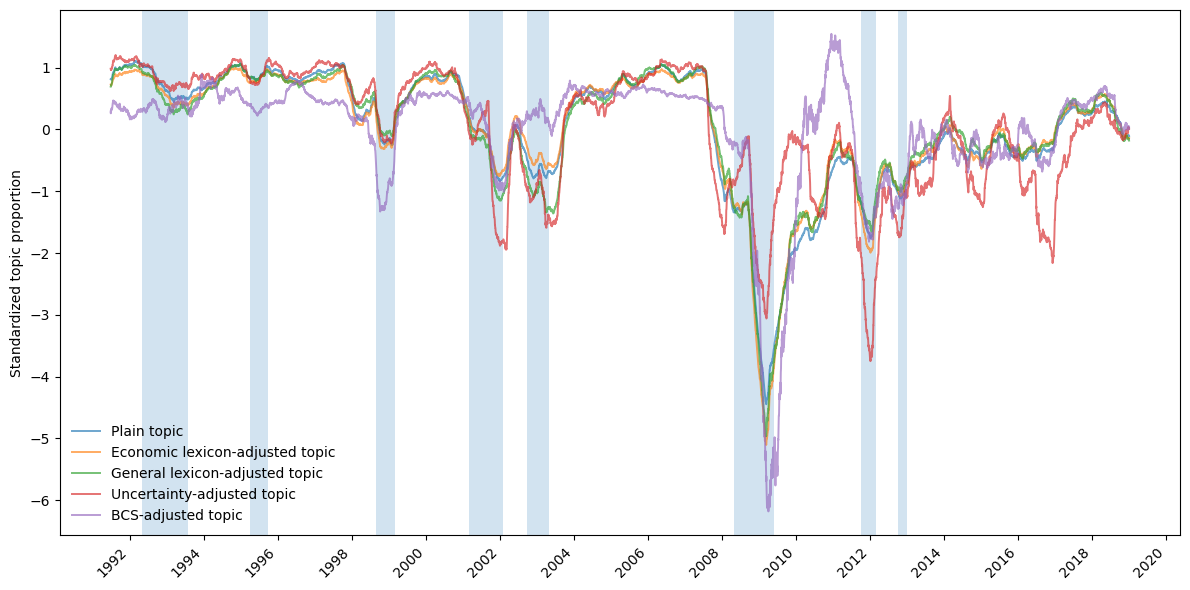

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

########### Helper functions #############

def load_daily_topics_csv(path, drop_first_col = False):
    """
    Load a CSV that contains year/month/day columns and topic columns.
    """
    df = pd.read_csv(path, encoding = "utf-8")
    if drop_first_col:
        df = df.iloc[:, 1:]
        
    df["date"] = pd.to_datetime(df[["year", "month", "day"]])
    df = df.drop(columns=["year", "month", "day"]).set_index("date").sort_index()
    return df

def rolling_mean(df, window_days = 180):
    "Compute rolling mean with a fixed window size in days."
    return df.rolling(window = window_days).mean()

def zscore(s):
    return (s-s.mean()) / s.std()

########### Inputs #############

# Paths
plain_path = Path("../topics/daily_topics.csv")
bpw_path = Path("sentiment_adjusted_daily_topics.csv")
sentiws_path = Path("sentiment_adjusted_daily_topics_SentiWS.csv")
unc_path = Path("../uncertainty/uncertainty_adjusted_daily_topics.csv")
bcs_path = Path("sign_adjusted_daily_topics_format.csv")

# Output directory
outdir = Path("T50_T27_adjustment_comparison")
outdir.mkdir(parents = True, exist_ok = True)

# Recession windows for shading
recessions = [
    ("1992-05-01", "1993-07-31"),  # Post-reunification recession
    ("1995-04-01", "1995-09-30"),  # Mid-1990s slowdown
    ("1998-08-31", "1999-02-28"),  # Asian/Russian crisis slowdown
    ("2001-03-01", "2002-01-31"),  # Dot-com recession
    ("2002-10-01", "2003-04-30"),  # Early-2000s stagnation
    ("2008-04-30", "2009-05-31"),  # Great Recession
    ("2011-09-30", "2012-02-28"),  # European sovereign debt crisis (phase 1)
    ("2012-09-30", "2012-12-31"),  # European sovereign debt crisis (phase 2)
]

# Topic indices for visualization
Topic_plain = 50
Topic_bcs = 27

rolling_window = 180

########### Load and transform data #############
daily_topics = load_daily_topics_csv(plain_path)
bpw_topics = load_daily_topics_csv(bpw_path, drop_first_col=True)
sentiws_topics = load_daily_topics_csv(sentiws_path, drop_first_col=True)
unc_topics = load_daily_topics_csv(unc_path, drop_first_col=True)
bcs_topics = load_daily_topics_csv(bcs_path)

daily_topics_rm = rolling_mean(daily_topics, window_days = rolling_window)
bpw_rm = rolling_mean(bpw_topics, window_days = rolling_window)
sentiws_rm = rolling_mean(sentiws_topics, window_days = rolling_window)
unc_rm = rolling_mean(unc_topics, window_days = rolling_window)
bcs_rm = rolling_mean(bcs_topics, window_days = rolling_window)

########### Build the five series #############

# Flip the sign of the topic for comparability
plain = -daily_topics_rm.iloc[:, Topic_plain]
econ_lex = bpw_rm.iloc[:, Topic_plain]
gen_lex = sentiws_rm.iloc[:, Topic_plain]
# Flip the sign of the uncertainty-adjusted topic for comparability
uncert = -unc_rm.iloc[:, Topic_plain]
bcs = bcs_rm.iloc[:, Topic_bcs]

# Standardize
series = {
    "Plain topic": zscore(plain),
    "Economic lexicon-adjusted topic": zscore(econ_lex),
    "General lexicon-adjusted topic": zscore(gen_lex),
    "Uncertainty-adjusted topic": zscore(uncert),
    "BCS-adjusted topic": zscore(bcs)
}

########### Plot #############
fig, ax = plt.subplots(figsize = (12, 6))

# Shading
for start, end in recessions:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.20)
    
# Plot with visual hierarchy (emphasize BCS and plain)
for label, s in series.items():
    is_important = label in {}
    ax.plot(
        s.index, s.values,
        label=label,
        linewidth=2.6 if is_important else 1.4,
        alpha=0.95 if is_important else 0.65,
        linestyle="--" if is_important else "-"
    )
    
ax.set_ylabel("Standardized topic proportion")
ax.set_xlabel("")

# Dates
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Legend
ax.legend(frameon=False, loc="lower left")

fig.tight_layout()

# Save
png_path = outdir / "crisis_topic_adjustments.png"
fig.savefig(png_path, dpi=300, bbox_inches="tight")

plt.show()
plt.close(fig)

Load 10 top words + corresponding probabilities

In [2]:
import numpy as np

def load_top_words(path, topic_id, top_n=10):
    """
    Return the df with ["word", "prob", "pct"] sorted by prob descending.
    """
    
    df = pd.read_csv(path, header=None, encoding="utf-8")
    
    topic_key = f"topic{topic_id}"
    # Find the row index where first column equals "topic50"
    matches = df.index[df.iloc[:,0].astype(str).str.strip() == topic_key].to_list()
    if not matches:
        raise ValueError(f"Could not find row starting with '{topic_key}' in {path}")
    
    i = matches[0]
    if i+1 >= len(df):
        raise ValueError(f"Found '{topic_key}' row at the end of file; no probability row available.")
        
    words_row = df.iloc[i, 1:]
    probs_row = df.iloc[i + 1, 1:]
    
    # Drop missing/empty
    words = words_row.dropna().astype(str).str.strip()
    probs = pd.to_numeric(probs_row.iloc[:len(words)], errors="coerce")
    
    out = pd.DataFrame({"word": words.values, "prob": probs.values}).dropna()
    out = out.sort_values("prob", ascending=False).head(top_n).reset_index(drop=True)
    out["pct"] = 100 * out["prob"]
    
    return out

topic_desc_path = Path("../topics/topic_description.csv")
top_words = load_top_words(topic_desc_path, topic_id=50, top_n=10)
top_words

,word,prob,pct
0,kris,0.056,5.6
1,tief,0.022,2.2
2,schlecht,0.018,1.8
3,folg,0.018,1.8
4,verlust,0.017,1.7
5,schwer,0.017,1.7
6,verlor,0.016,1.6
7,dramat,0.012,1.2
8,angesicht,0.012,1.2
9,massiv,0.010,1.0


The plot with time series on the left side and words with corresponding probabilities on the right side

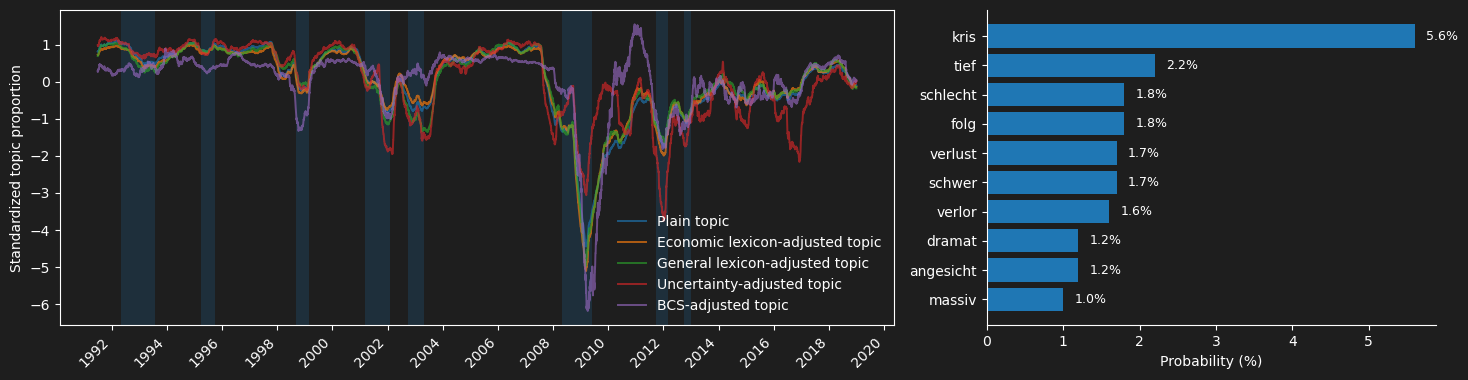

In [3]:
plt.rcParams.update({
    "figure.facecolor": "#1e1e1e",
    "axes.facecolor": "#1e1e1e",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "legend.frameon": False,
})

fig, (ax_left, ax_right) = plt.subplots(ncols = 2,
                                       figsize = (14.8, 3.9),
                                       gridspec_kw={"width_ratios": [2.6, 1.4]})

# LEFT PANEL

# Shading
for start, end in recessions:
    ax_left.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.20)
    
# Plot time series
for label, s in series.items():
    is_important = label in {}
    ax_left.plot(
        s.index, s.values,
        label=label,
        linewidth=2.6 if is_important else 1.4,
        alpha=0.95 if is_important else 0.65,
        linestyle="--" if is_important else "-"
    )
    
ax_left.set_ylabel("Standardized topic proportion")
ax_left.set_xlabel("")

# Dates
ax_left.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax_left.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax_left.get_xticklabels(), rotation=45, ha="right")

# Legend
ax_left.legend(frameon=False, loc="lower right")

# RIGHT PANEL

# Reverse order
for_plot = top_words[::-1].copy()
ax_right.barh(for_plot["word"], for_plot["pct"])
ax_right.set_xlabel("Probability (%)")

# Add value labels at the end of bars
for y, val in enumerate(for_plot["pct"]):
    ax_right.text(val + 0.15, y, f"{val:.1f}%", va="center", fontsize=9)
    
# Clean up right panel
ax_right.spines["top"].set_visible(False)
ax_right.spines["right"].set_visible(False)

fig.tight_layout()

# Save to the folder
png_path = outdir / "crisis_topic_adjustments_with_top_words.png"
fig.savefig(png_path, dpi=100, bbox_inches="tight")

plt.show()
plt.close(fig)